In [1]:
!pip install pybaseball

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.9/375.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 15.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import statcast
pd.set_option('display.max_columns', None)

In [4]:
# query 2024 data
df = statcast('2024-03-28', '2024-09-29')

# get rid of warning when doing stuff with loc
df = df.copy()
# pick relevant columns
cols = ['pitch_type', 'p_throws', 'release_speed', 'release_extension', 'pfx_x', 'pfx_z', 'ax', 'az']
df = df[cols]
# drop missing data
df = df.dropna().reset_index(drop=True)
 # drop weird pitches
df = df.loc[~df['pitch_type'].isin(['CS', 'PO', 'EP', 'KN', 'FA',])]
# create pitch category col
df['pitch_category'] = df['pitch_type'].apply(lambda x: 'FASTBALL' if x in ['FF', 'SI', 'FC'] else
                                               'BREAKING' if x in ['SL', 'CU', 'ST', 'KC', 'SV', 'SC'] else
                                               'OFFSPEED' if x in ['CH', 'FS', 'FO'] else
                                               'NA')
# flip lefty horizontal movement
df.loc[df['p_throws']=='L', 'pfx_x'] = df.loc[df['p_throws']=='L', 'pfx_x']*-1
df.loc[df['p_throws']=='L', 'ax'] = df.loc[df['p_throws']=='L', 'ax']*-1
# convert to in per sec
df['release_speed_in_per_sec'] = df['release_speed'] * 17.6
# get mound to home plate distance in inches
df['distance_to_plate_in'] = 726 - (12*df['release_extension'])
# get time to plate in sec
df['time_to_plate_sec'] = df['distance_to_plate_in']/df['release_speed_in_per_sec']

This is a large query, it may take a moment to complete


/usr/local/lib/python3.10/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
  0%|          | 0/186 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_co

In [4]:
df.head()

,pitch_type,p_throws,release_speed,release_extension,pfx_x,pfx_z,ax,az,pitch_category,release_speed_in_per_sec,distance_to_plate_in,time_to_plate_sec
0,FF,R,94.8,6.9,-0.33,1.61,-5.060805,-9.493986,FASTBALL,1668.48,643.2,0.385501
1,FC,R,90.1,6.8,0.22,0.65,2.116835,-23.615098,FASTBALL,1585.76,644.4,0.406367
2,FF,R,94.2,6.8,-0.41,1.66,-6.179014,-10.385366,FASTBALL,1657.92,644.4,0.38868
3,FF,R,95.2,6.9,-0.22,1.65,-4.290866,-8.719818,FASTBALL,1675.52,643.2,0.383881
4,FF,R,95.0,6.8,-0.31,1.61,-4.321102,-10.137251,FASTBALL,1672.0,644.4,0.385407


In [7]:
df.shape

(704886, 12)

In [5]:
print(round(df['release_speed'].corr(df['time_to_plate_sec'])*-1, 4))

0.9884


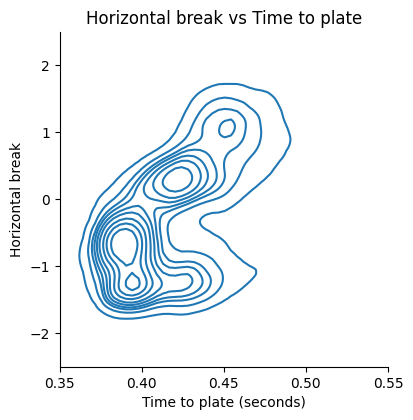

In [15]:
sns.pairplot(data=df, x_vars='time_to_plate_sec', y_vars='pfx_x', kind='kde', height = 4)
plt.xlabel('Time to plate (seconds)')
plt.ylabel('Horizontal break')
plt.title('Horizontal break vs Time to plate')
plt.ylim([-2.5, 2.5])
plt.xlim([0.35, 0.55])
plt.show()

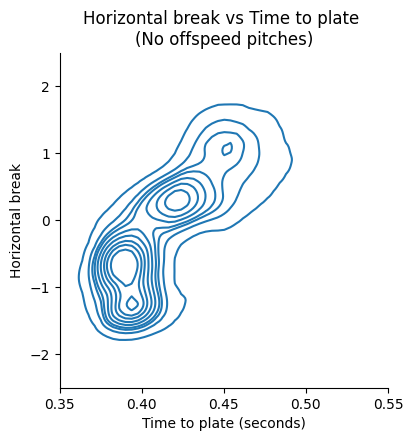

In [29]:
sns.pairplot(data=df.loc[df['pitch_category'] != 'OFFSPEED'], x_vars='time_to_plate_sec', y_vars='pfx_x', kind='kde', height = 4)
plt.xlabel('Time to plate (seconds)')
plt.ylabel('Horizontal break')
plt.title('Horizontal break vs Time to plate \n(No offspeed pitches)')
plt.ylim([-2.5, 2.5])
plt.xlim([0.35, 0.55])
plt.show()

In [23]:
df.loc[df['pfx_x'] < 0, 'pitch_category'].value_counts(normalize=True)

,proportion
pitch_category,
FASTBALL,0.766466
OFFSPEED,0.209939
BREAKING,0.023595


In [24]:
df.loc[df['pfx_x'] > 0, 'pitch_category'].value_counts(normalize=True)

,proportion
pitch_category,
BREAKING,0.791629
FASTBALL,0.206533
OFFSPEED,0.001838


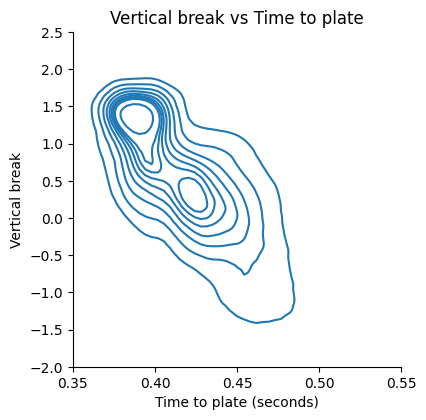

In [16]:
sns.pairplot(data=df, x_vars='time_to_plate_sec', y_vars='pfx_z', kind='kde', height = 4)
plt.xlabel('Time to plate (seconds)')
plt.ylabel('Vertical break')
plt.title('Vertical break vs Time to plate')
plt.ylim([-2, 2.5])
plt.xlim([0.35, 0.55])
plt.show()

In [21]:
df.loc[df['pfx_z'] > 0, 'pitch_category'].value_counts(normalize=True)

,proportion
pitch_category,
FASTBALL,0.682679
BREAKING,0.178732
OFFSPEED,0.138589


In [22]:
df.loc[df['pfx_z'] < 0, 'pitch_category'].value_counts(normalize=True)

,proportion
pitch_category,
BREAKING,0.831425
OFFSPEED,0.108221
FASTBALL,0.060353


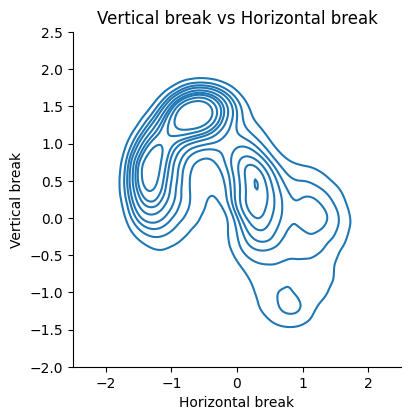

In [17]:
sns.pairplot(data=df, x_vars='pfx_x', y_vars='pfx_z', kind='kde', height = 4)
plt.xlabel('Horizontal break')
plt.ylabel('Vertical break')
plt.title('Vertical break vs Horizontal break')
plt.ylim([-2, 2.5])
plt.xlim([-2.5, 2.5])
plt.show()

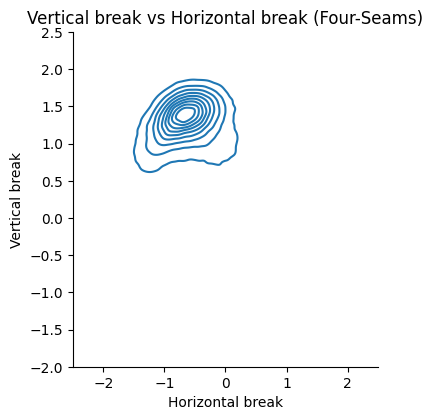

In [20]:
sns.pairplot(data=df.loc[df['pitch_type']=='FF'], x_vars='pfx_x', y_vars='pfx_z', kind='kde', height = 4)
plt.xlabel('Horizontal break')
plt.ylabel('Vertical break')
plt.title('Vertical break vs Horizontal break (Four-Seams)')
plt.ylim([-2, 2.5])
plt.xlim([-2.5, 2.5])
plt.show()

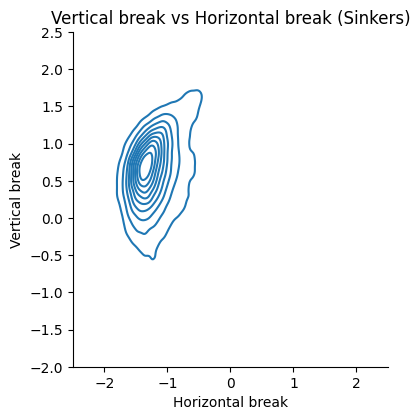

In [19]:
sns.pairplot(data=df.loc[df['pitch_type']=='SI'], x_vars='pfx_x', y_vars='pfx_z', kind='kde', height = 4)
plt.xlabel('Horizontal break')
plt.ylabel('Vertical break')
plt.title('Vertical break vs Horizontal break (Sinkers)')
plt.ylim([-2, 2.5])
plt.xlim([-2.5, 2.5])
plt.show()

In [25]:
df[:1000].shape

(1000, 12)

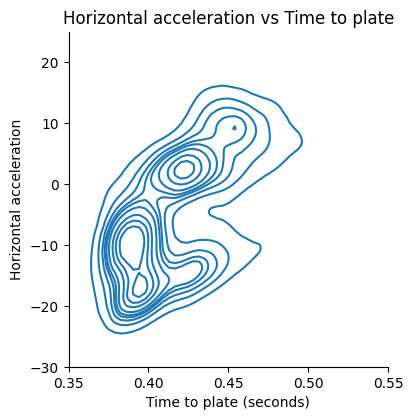

In [28]:
sns.pairplot(data=df, x_vars='time_to_plate_sec', y_vars='ax', kind='kde', height = 4)
plt.xlabel('Time to plate (seconds)')
plt.ylabel('Horizontal acceleration')
plt.title('Horizontal acceleration vs Time to plate')
plt.ylim([-30, 25])
plt.xlim([0.35, 0.55])
plt.show()

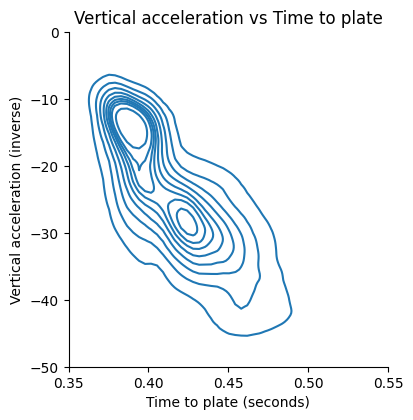

In [9]:
sns.pairplot(data=df, x_vars='time_to_plate_sec', y_vars='az', kind='kde', height = 4)
plt.xlabel('Time to plate (seconds)')
plt.ylabel('Vertical acceleration (inverse)')
plt.title('Vertical acceleration vs Time to plate')
plt.ylim([-50, 0])
plt.xlim([0.35, 0.55])
plt.show()

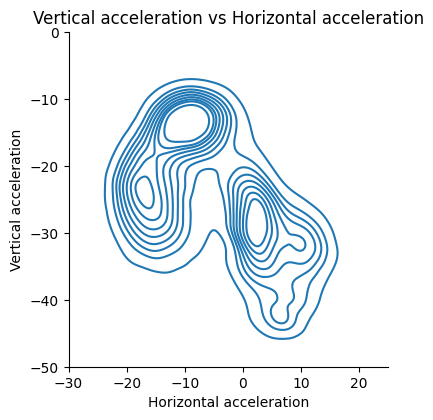

In [12]:
sns.pairplot(data=df, x_vars='ax', y_vars='az', kind='kde', height = 4)
plt.xlabel('Horizontal acceleration')
plt.ylabel('Vertical acceleration')
plt.title('Vertical acceleration vs Horizontal acceleration')
plt.xlim([-30, 25])
plt.ylim([-50, 0])
plt.show()